# 心血管疾病预测

*平台上训练可能比较慢，你可以从[这里](https://isrc.iscas.ac.cn/gitlab/summer2020/students/proj-2033168/-/blob/master/predict.ipynb)得到每个单元的输出，也可以在 [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/LovelyBuggies/Python_Cardiovascular_Disease_Predict/master?filepath=predict.ipynb) 上发布以训练。*

在分类问题中，分类的目的是从一组数据中选择一个类别（例如，给出一张苹果或橘子的图片，并确定图片中的水果是什么）。本项目使用心血管疾病数据集，该数据集提供11个特征值和1个目标值，包含70,000例患者记录的数据。建立了预测样本是否有心血管疾病的算法模型。本次实训主要介绍如何实现“心血管疾病预测模型”的开发。

## 数据预处理

我们首先从 Kaggle 数据集 https://www.kaggle.com/sulianova/cardiovascular-disease-dataset 中下载数据，并将数据放到合适的文件夹以供加载。

### 数据探索

我们首先探索一下该数据集的数据特征。

In [1]:
import os
import pandas as pd

用 pandas 读取数据集，并显示数据开头的项，或者显示数据项类型。我们可以看出，载入的数据中包含年龄、性别、吸烟与否等各项指标，以及它们对应的数据量和数据类型。

In [2]:
data = pd.read_csv("./data/cardio_train.csv", sep=";")
# data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


接下来，我们需要剔除数据中的无效值，即血压过高或者过低的值，并设置一个新的表项体脂率 `bmi`。

In [3]:
if "id" in data:
    data.drop("id",axis=1,inplace=True)

data.drop_duplicates(inplace=True)
data["bmi"] = data["weight"] / (data["height"]/100)**2
out_lier = (data["ap_hi"] > 250) | (data["ap_lo"] > 200) | (data["ap_hi"] < 0) | (data["ap_lo"] < 0)
data = data[~out_lier]
# data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68975 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          68975 non-null  int64  
 1   gender       68975 non-null  int64  
 2   height       68975 non-null  int64  
 3   weight       68975 non-null  float64
 4   ap_hi        68975 non-null  int64  
 5   ap_lo        68975 non-null  int64  
 6   cholesterol  68975 non-null  int64  
 7   gluc         68975 non-null  int64  
 8   smoke        68975 non-null  int64  
 9   alco         68975 non-null  int64  
 10  active       68975 non-null  int64  
 11  cardio       68975 non-null  int64  
 12  bmi          68975 non-null  float64
dtypes: float64(2), int64(11)
memory usage: 7.4 MB


### 配置文件报告

`pandas_profiling` 是一个从 pandas `dataFrame` 中生成配置文件报告的工具。我们在此使用它，将生成的报告导出成 HTML 格式。

In [4]:
from pandas_profiling import ProfileReport

profile = ProfileReport(data, title='Cardio-Disease Report', explorative=True)
# profile.to_notebook_iframe()
if not os.path.exists("cardio_report.html"):
    profile.to_file("cardio_report.html")

/usr/local/lib/python3.7/site-packages/pandas_profiling/visualisation/plot.py:154: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad(cmap_bad)


### 分离数据

接下来，我们需要分离数据。我们现将标签和真值分离出来。然后，我们使用了 `sklearn.model_selection` 中的分离函数，设置分离比率为 9 比 1，分离之后训练集中还有 62077 个项，验证集中含有 6898 个项。

In [5]:
labels = data['cardio']
data = data.drop(['cardio'], axis=1)

In [6]:
from sklearn.model_selection import train_test_split

train, valid, train_labels, ground_truth = train_test_split(data, labels, test_size=0.1, random_state=0)
train.info()
valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62077 entries, 709 to 69281
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          62077 non-null  int64  
 1   gender       62077 non-null  int64  
 2   height       62077 non-null  int64  
 3   weight       62077 non-null  float64
 4   ap_hi        62077 non-null  int64  
 5   ap_lo        62077 non-null  int64  
 6   cholesterol  62077 non-null  int64  
 7   gluc         62077 non-null  int64  
 8   smoke        62077 non-null  int64  
 9   alco         62077 non-null  int64  
 10  active       62077 non-null  int64  
 11  bmi          62077 non-null  float64
dtypes: float64(2), int64(10)
memory usage: 6.2 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 51756 to 14694
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          6898 non-null   int64  
 1   gender 

## Scikit-Learn 模型

Scikit-learn (Sklearn) 是基于 Python 语言的机器学习工具，其中提供了很多机器学习工具的接口可以帮助我们进行数据分析。我们首先用 Sklearn 中的一些接口进行分析。

In [7]:
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from xgboost.sklearn import XGBClassifier
from lightgbm.sklearn import LGBMClassifier

import matplotlib.pyplot as plt

### 逻辑回归

逻辑回归是在工作流早期运行的一个有用的模型。逻辑回归通过使用 Logistic 函数估计概率来衡量分类因变量（特征）和一个或多个自变量（特征）之间的关系，这是累计 Logistic 分布。首先，载入一个逻辑回归预测器并进行拟合：

In [8]:
logreg = LogisticRegression()
logreg.fit(train, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

然后，我们可以得到训练集和验证集的预测准确率：

In [9]:
acc_logreg_train = round(logreg.score(train, train_labels) * 100, 2)
acc_logreg_valid = round(logreg.score(valid, ground_truth) * 100, 2)

print(f"Train Set Accuracy: {acc_logreg_train}%; Validation Set Accuracy: {acc_logreg_valid}%.")

Train Set Accuracy: 71.72%; Validation Set Accuracy: 71.96%.


### 支持向量机

支持向量机是监督学习模型与相关的学习算法，分析用于分类和回归分析的数据。给定一组训练样本，每个样本都被标记为属于两个类别中的一个或另一个类别，SVM 训练算法建立一个模型，将新的测试样本分配给一个类别或另一个类别，使其成为一个非概率二值线性分类器。首先加载一个支持向量机并对训练集进行拟合：

In [10]:
svc = SVC(max_iter=1000)
svc.fit(train, train_labels)

/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=1000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

然后，我们可以得到训练集和验证集的预测准确率：

In [11]:
acc_svc_train = round(svc.score(train, train_labels) * 100, 2)
acc_svc_valid = round(svc.score(valid, ground_truth) * 100, 2)

print(f"Train Set Accuracy: {acc_svc_train}%; Validation Set Accuracy: {acc_svc_valid}%.")

Train Set Accuracy: 56.63%; Validation Set Accuracy: 57.03%.


### K 近邻

在模式识别中，K 近邻算法是一种用于分类和回归的非参数方法。一个样本由其邻居的多数投票来分类，该样本被分配到它的 K 个最近邻居中最常见的类。载入一个网格搜索器，并用 KNN 分类器作为评估器，然后进行拟合：

In [12]:
knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid={'n_neighbors': [3, 3]}, cv=10)
knn.fit(train, train_labels)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None, param_grid={'n_neighbors': [3, 3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

然后，我们可以得到训练集和验证集的预测准确率：

In [13]:
acc_knn_train = round(knn.score(train, train_labels) * 100, 2)
acc_knn_valid = round(knn.score(valid, ground_truth) * 100, 2)

print(f"Train Set Accuracy: {acc_knn_train}%; Validation Set Accuracy: {acc_knn_valid}%.")

Train Set Accuracy: 81.46%; Validation Set Accuracy: 67.18%.


### 岭分类

岭回归是最常用的回归算法来找到一个没有唯一解的方程的答案近似值。这种类型的问题在机器学习任务中非常常见，在这种任务中，必须使用有限的数据来选择“最佳”的解决方案。如果存在唯一解，算法将返回最优值。但是，如果存在多种解决方案，它可以选择其中任何一种。因为这里是一个分类问题，我们先载入一个岭分类器，并进行拟合：

In [14]:
ridge = RidgeClassifier()
ridge.fit(train, train_labels)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

然后，我们可以得到训练集和验证集的预测准确率：

In [15]:
acc_ridge_train = round(ridge.score(train, train_labels) * 100, 2)
acc_ridge_valid = round(ridge.score(valid, ground_truth) * 100, 2)

print(f"Train Set Accuracy: {acc_ridge_train}%; Validation Set Accuracy: {acc_ridge_valid}%.")

Train Set Accuracy: 72.37%; Validation Set Accuracy: 72.41%.


### 袋分类

袋分类器是一种集成元估计器，它适合原始数据集的随机子集上的基分类器，然后聚合它们各自的预测以形成最终的预测。这种元估计器通常可以用来减少黑箱估计器的方差，方法是在构造过程中引入随机化，然后对其进行集成。

In [16]:
bagging = BaggingClassifier()
bagging.fit(train, train_labels)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

然后，我们可以得到训练集和验证集的预测准确率：

In [17]:
acc_bagging_train = round(bagging.score(train, train_labels) * 100, 2)
acc_bagging_valid = round(bagging.score(valid, ground_truth) * 100, 2)

print(f"Train Set Accuracy: {acc_bagging_train}%; Validation Set Accuracy: {acc_bagging_valid}%.")

Train Set Accuracy: 97.98%; Validation Set Accuracy: 69.57%.


### 高斯朴素贝叶斯

在机器学习中，朴素贝叶斯分类器是一组基于贝叶斯定理的简单概率分类器，具有特征之间的强独立性假设。朴素贝叶斯分类器是高度可扩展的，需要大量的参数在变量的数量线性学习问题。首先，我们先载入一个高斯朴素贝叶斯分类器，并拟合训练集：

In [18]:
gnb = GaussianNB()
gnb.fit(train, train_labels)

GaussianNB(priors=None, var_smoothing=1e-09)

然后，我们可以得到训练集和验证集的预测准确率：

In [19]:
acc_gnb_train = round(gnb.score(train, train_labels) * 100, 2)
acc_gnb_valid = round(gnb.score(valid, ground_truth) * 100, 2)

print(f"Train Set Accuracy: {acc_gnb_train}%; Validation Set Accuracy: {acc_gnb_valid}%.")

Train Set Accuracy: 70.27%; Validation Set Accuracy: 69.79%.


### 感知器

感知器是一个二进制分类器的监督学习算法（函数可以决定输入是否属于某个特定的类，由数字向量表示）。它是一种线性分类器，即基于线性预测函数结合一组权值和特征向量进行预测的分类算法。同样，我们载入一个感知器，然后进行拟合：

In [20]:
perceptron = Perceptron()
perceptron.fit(train, train_labels)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

然后，我们就能得到训练集和验证集的预测准确率：

In [21]:
acc_perceptron_train = round(perceptron.score(train, train_labels) * 100, 2)
acc_perceptron_valid = round(perceptron.score(valid, ground_truth) * 100, 2)

print(f"Train Set Accuracy: {acc_perceptron_train}%; Validation Set Accuracy: {acc_perceptron_valid}%.")

Train Set Accuracy: 66.65%; Validation Set Accuracy: 65.76%.


### 随机梯度下降

随机梯度下降是一种迭代方法，用于优化具有适当光滑性的目标函数。它可以被看作是梯度下降优化的一种随机近似，因为它将实际的梯度替换为一个估计。特别是在大数据应用程序中，这减少了计算负担，实现了更快的迭代，但收敛速度略低。首先，载入一个 SGD 分类器，进行拟合：

In [22]:
sgd = SGDClassifier()
sgd.fit(train, train_labels)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

然后，我们就能得到训练集和验证集的预测准确率：

In [23]:
acc_sgd_train = round(sgd.score(train, train_labels) * 100, 2)
acc_sgd_valid = round(sgd.score(valid, ground_truth) * 100, 2)

print(f"Train Set Accuracy: {acc_sgd_train}%; Validation Set Accuracy: {acc_sgd_valid}%.")

Train Set Accuracy: 56.01%; Validation Set Accuracy: 55.47%.


### 决策树

决策树分类器将特征（枝）映射到关于目标值（叶）的结论。目标变量可以取有限的一组值的树模型称为分类树;在这些树形结构中，叶子表示类标签，分支表示连接到这些类标签的特征。目标变量可以取连续值的决策树称为回归树。我们载入一个决策树分类器并进行拟合：

In [24]:
dt = DecisionTreeClassifier()
dt.fit(train, train_labels)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

然后，我们就能得到训练集和验证集的预测准确率：

In [25]:
acc_dt_train = round(dt.score(train, train_labels) * 100, 2)
acc_dt_valid = round(dt.score(valid, ground_truth) * 100, 2)

print(f"Train Set Accuracy: {acc_dt_train}%; Validation Set Accuracy: {acc_dt_valid}%.")

Train Set Accuracy: 99.98%; Validation Set Accuracy: 63.61%.


### 随机森林

随机森林是一个包含多个决策树的分类器， 并且其输出的类别是由个别树输出的类别的众数而定。我们创建一个网格搜索器，并用随机森林分类器作为估计器，对训练集进行拟合，

In [26]:
rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid={'n_estimators': [100, 300]}, cv=5)
rf.fit(train, train_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

然后，我们就能得到训练集和验证集的预测准确率：

In [27]:
acc_rf_train = round(rf.score(train, train_labels) * 100, 2)
acc_rf_valid = round(rf.score(valid, ground_truth) * 100, 2)

print(f"Train Set Accuracy: {acc_rf_train}%; Validation Set Accuracy: {acc_rf_valid}%.")

Train Set Accuracy: 99.97%; Validation Set Accuracy: 71.82%.


### 极端随机树

极端随机树实现了一个元估计器，它在数据集的各个子样本上匹配极端随机树，并使用平均来提高预测精度和控制过拟合。控制树大小的参数的默认值会导致完全生长和未修剪的树，在某些数据集上可能会非常大。为了减少内存消耗，应该通过设置这些参数值来控制树的复杂性和大小。在载入极端随机树之前，我们先用 `hyperopt_et_score` 工具找到合适的超参数，然后构建分类器，并进行拟合：

In [28]:
def hyperopt_et_score(params):
    et = ExtraTreesClassifier(**params)
    score = cross_val_score(et, train, train_labels, cv=10).mean()
    print(score, params)
    return score 
 
hyperopt_et_space = {
            'n_estimators': hp.choice('n_estimators', range(100, 150)),
            'max_features': hp.choice('max_features', range(2, 17)),
            'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 5)),
            'max_depth':  hp.choice('max_depth', range(1, 5)),
            'max_features': None,
        }
 
best_et = fmin(fn=hyperopt_et_score, space=hyperopt_et_space, algo=tpe.suggest, max_evals=10)
best_et_param = space_eval(hyperopt_et_space, best_et)
print("Best Extra Trees Param")
print(best_et_param)

0.7200249520827001                                    
{'max_depth': 3, 'max_features': None, 'min_samples_leaf': 3, 'n_estimators': 103}
0.7251478159427583                                                              
{'max_depth': 4, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 149}
0.6595201325324418                                                              
{'max_depth': 1, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 131}
0.6576978711473079                                                              
{'max_depth': 1, 'max_features': None, 'min_samples_leaf': 3, 'n_estimators': 135}
0.7207339459398185                                                              
{'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 137}
0.7245678723224029                                                              
{'max_depth': 4, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 143}
0.7193646436970896                        

In [29]:
et = ExtraTreesClassifier(**best_et_param)
et.fit(train, train_labels)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=1, max_features=None,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=3, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=135,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

然后，我们就能得到训练集和验证集的预测准确率：

In [30]:
acc_et_train = round(et.score(train, train_labels) * 100, 2)
acc_et_valid = round(et.score(valid, ground_truth) * 100, 2)

print(f"Train Set Accuracy: {acc_et_train}%; Validation Set Accuracy: {acc_et_valid}%.")

Train Set Accuracy: 66.93%; Validation Set Accuracy: 66.6%.


### 梯度提升

梯度提升是增强算法中的一大类算法，它的思想借鉴于梯度下降法，其基本原理是根据当前模型损失函数的负梯度信息来训练新加入的弱分类器，然后将训练好的弱分类器以累加的形式结合到现有模型中。在载入梯度提升分类器前，我们需要找到合适的超参数，然后进行拟合：

In [31]:
def hyperopt_gb_score(params):
    gb = GradientBoostingClassifier(**params)
    score = cross_val_score(gb, train, train_labels, cv=10).mean()
    print(score, params)
    return score 
 
hyperopt_gb_space = {
            'n_estimators': hp.choice('n_estimators', range(100, 900)),
            'max_depth': hp.choice('max_depth', range(2, 10))          
        }
 
best_gb = fmin(fn=hyperopt_gb_score, space=hyperopt_gb_space, algo=tpe.suggest, max_evals=10)
best_gb_param = space_eval(hyperopt_gb_space, best_gb)
print("Best Gradient Boosting Param")
print(best_gb_param)

0.7330411815766701                                    
{'max_depth': 2, 'n_estimators': 128}                 
0.7159978980125532                                                              
{'max_depth': 8, 'n_estimators': 753}                                           
0.7322357328730947                                                               
{'max_depth': 3, 'n_estimators': 723}                                            
0.7299321938026405                                                               
{'max_depth': 5, 'n_estimators': 571}                                              
0.7307215212829213                                                                    
{'max_depth': 5, 'n_estimators': 520}                                                 
0.7326545784481769                                                                    
{'max_depth': 2, 'n_estimators': 840}                                                 
0.7335244912835358                                

In [32]:
gb = GradientBoostingClassifier(**best_gb_param)
gb.fit(train, train_labels)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=9,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=618,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

然后，我们就能得到训练集和验证集的预测准确率：

In [33]:
acc_gb_train = round(gb.score(train, train_labels) * 100, 2)
acc_gb_valid = round(gb.score(valid, ground_truth) * 100, 2)

print(f"Train Set Accuracy: {acc_gb_train}%; Validation Set Accuracy: {acc_gb_valid}%.")

Train Set Accuracy: 93.87%; Validation Set Accuracy: 71.69%.


### AdaBoost

Adaboost是一种迭代算法，其核心思想是针对同一个训练集训练不同的分类器(弱分类器)，然后把这些弱分类器集合起来，构成一个更强的最终分类器（强分类器）。在载入 AdaBoost 分类器前，我们需要找到合适的超参数，然后进行拟合：

In [34]:
def hyperopt_ab_score(params):
    ab = AdaBoostClassifier(**params)
    score = cross_val_score(ab, train, train_labels, cv=10).mean()
    print(score, params)
    return score 
 
hyperopt_ab_space = {
            'n_estimators': hp.choice('n_estimators', range(100, 300)),
            'learning_rate': hp.quniform('learning_rate', 0.01, 0.05, 0.01)       
        }
 
best_ab = fmin(fn=hyperopt_ab_score, space=hyperopt_ab_space, algo=tpe.suggest, max_evals=10)
best_ab_param = space_eval(hyperopt_ab_space, best_ab)
print("Best AdaBoost Param")
print(best_ab_param)

0.7227797037431966                                    
{'learning_rate': 0.04, 'n_estimators': 223}          
0.7246966863982965                                                              
{'learning_rate': 0.05, 'n_estimators': 298}                                    
0.7238106912672588                                                              
{'learning_rate': 0.04, 'n_estimators': 290}                                    
0.7225542298020693                                                              
{'learning_rate': 0.04, 'n_estimators': 189}                                    
0.7170932821938648                                                              
{'learning_rate': 0.02, 'n_estimators': 196}                                    
0.7194291130192217                                                              
{'learning_rate': 0.05, 'n_estimators': 102}                                    
0.7183175842580458                                                              

In [35]:
ab = AdaBoostClassifier(**best_ab_param)
ab.fit(train, train_labels)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.03,
                   n_estimators=123, random_state=None)

然后，我们就能得到训练集和验证集的预测准确率：

In [36]:
acc_ab_train = round(ab.score(train, train_labels) * 100, 2)
acc_ab_valid = round(ab.score(valid, ground_truth) * 100, 2)

print(f"Train Set Accuracy: {acc_ab_train}%; Validation Set Accuracy: {acc_ab_valid}%.")

Train Set Accuracy: 71.65%; Validation Set Accuracy: 72.06%.


### XGBoost

XGBoost 在普通增强算法的基础上，提供了一种并行树推进，可以快速、准确地解决许多数据科学问题。在载入 XGBoost 分类器前，我们需要找到合适的超参数，然后进行拟合：

In [37]:
def hyperopt_xgb_score(params):
    xgb = XGBClassifier(**params)
    score = cross_val_score(xgb, train, train_labels, cv=10).mean()
    print(score, params)
    return score 
 
hyperopt_xgb_space = {
            'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001),
            'n_estimators': hp.choice('n_estimators', range(700, 800)),
            'eta': hp.quniform('eta', 0.4, 0.5, 0.1),
            'max_depth':  hp.choice('max_depth', range(10, 12)),
            'min_child_weight': hp.quniform('min_child_weight', 5, 7, 0.1),
            'subsample': hp.quniform('subsample', 0.8, 1, 0.1),
            'gamma': hp.quniform('gamma', 0.9, 1, 0.1),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 0.7, 0.1),
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            'booster': 'gbtree',
            'tree_method': 'exact',
            'missing': None
        }
 
best_xgb = fmin(fn=hyperopt_xgb_score, space=hyperopt_xgb_space, algo=tpe.suggest, max_evals=10)
best_xgb_param = space_eval(hyperopt_xgb_space, best_xgb)
print("Best XGB Param")
print(best_xgb_param)

0.7318491453156479                                    
{'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'eta': 0.5, 'eval_metric': 'auc', 'gamma': 1.0, 'learning_rate': 0.0199, 'max_depth': 11, 'min_child_weight': 6.300000000000001, 'missing': None, 'n_estimators': 718, 'objective': 'binary:logistic', 'subsample': 1.0, 'tree_method': 'exact'}
0.732332457617688                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'eta': 0.4, 'eval_metric': 'auc', 'gamma': 0.9, 'learning_rate': 0.0167, 'max_depth': 11, 'min_child_weight': 6.300000000000001, 'missing': None, 'n_estimators': 764, 'objective': 'binary:logistic', 'subsample': 0.8, 'tree_method': 'exact'}
0.7266781617320983                                                               
{'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'eta': 0.5, 'eval_metric': 'auc', 'gamma': 1.0, 'learning_rate': 0.049100000000000005, 'max_depth': 11, 'min_chil

In [38]:
xgb = XGBClassifier(**best_et_param)
xgb.fit(train, train_labels)

[22:11:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              max_features=None, min_child_weight=1, min_samples_leaf=3,
              missing=nan, monotone_constraints='()', n_estimators=135,
              n_jobs=0, num_parallel_tree=1, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

然后，我们就能得到训练集和验证集的预测准确率：

In [39]:
acc_xgb_train = round(xgb.score(train, train_labels) * 100, 2)
acc_xgb_valid = round(xgb.score(valid, ground_truth) * 100, 2)

print(f"Train Set Accuracy: {acc_xgb_train}%; Validation Set Accuracy: {acc_xgb_valid}%.")

Train Set Accuracy: 73.09%; Validation Set Accuracy: 73.62%.


### LightGBM

LightGBM 是一个使用基于树的学习算法的梯度增强框架，它不需要通过所有样本计算信息增益且内置特征降维技术，所以更加快速。在载入 LightGBM 分类器前，我们需要找到合适的超参数，然后进行拟合：

In [40]:
def hyperopt_lgbm_score(params):
    lgbm = LGBMClassifier(**params)
    score = cross_val_score(lgbm, train, train_labels, cv=10).mean()
    print(score, params)
    return score 
 
hyperopt_lgbm_space = {
            'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001),
            'n_estimators': hp.choice('n_estimators', range(500, 1000)),
            'max_depth':  hp.choice('max_depth', range(2, 12)),
            'num_leaves': hp.choice('num_leaves', range(2, 2**11)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 9, 0.05),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
            'objective': 'binary',
            'boosting_type': 'gbdt',
            }
 
best_lgbm = fmin(fn=hyperopt_lgbm_score, space=hyperopt_lgbm_space, algo=tpe.suggest, max_evals=10)
best_lgbm_param = space_eval(hyperopt_lgbm_space, best_lgbm)
print("Best LGBM Param")
print(best_lgbm_param)

0.7350548370728758                                    
{'boosting_type': 'gbdt', 'colsample_bytree': 0.55, 'learning_rate': 0.0134, 'max_depth': 5, 'min_child_weight': 5.3500000000000005, 'n_estimators': 722, 'num_leaves': 1307, 'objective': 'binary'}
0.734152676600579                                                               
{'boosting_type': 'gbdt', 'colsample_bytree': 0.55, 'learning_rate': 0.0413, 'max_depth': 2, 'min_child_weight': 7.15, 'n_estimators': 590, 'num_leaves': 595, 'objective': 'binary'}
0.7345554865931214                                                              
{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.049800000000000004, 'max_depth': 3, 'min_child_weight': 5.050000000000001, 'n_estimators': 993, 'num_leaves': 32, 'objective': 'binary'}
0.7357636804098798                                                             
{'boosting_type': 'gbdt', 'colsample_bytree': 0.75, 'learning_rate': 0.019100000000000002, 'max_depth': 5, 'min_child

In [41]:
lgbm = LGBMClassifier(**best_lgbm_param)
lgbm.fit(train, train_labels)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.6000000000000001, importance_type='split',
               learning_rate=0.0434, max_depth=11, min_child_samples=20,
               min_child_weight=4.25, min_split_gain=0.0, n_estimators=931,
               n_jobs=-1, num_leaves=679, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

然后，我们就能得到训练集和验证集的预测准确率：

In [42]:
acc_lgbm_train = round(lgbm.score(train, train_labels) * 100, 2)
acc_lgbm_valid = round(lgbm.score(valid, ground_truth) * 100, 2)

print(f"Train Set Accuracy: {acc_lgbm_train}%; Validation Set Accuracy: {acc_lgbm_valid}%.")

Train Set Accuracy: 83.14%; Validation Set Accuracy: 72.99%.


### 对比

接下来，我们将模型的结果汇总，并进行横向的对比。

In [43]:
res = pd.DataFrame({
    
    'model': [
        'Logistic Regression', 'Support Vector Machine', 'K-Nearest Neighbors', 
        'RidgeClassifier', 'BaggingClassifier', 'Naive Bayes', 'Perceptron',
        'Stochastic Gradient Decent', 'Decision Tree', 'Random Forest', 
        'ExtraTreesClassifier', 'GradientBoostingClassifier', 
        'AdaBoostClassifier','XGBClassifier', 'LGBMClassifier',
    ],
    
    'acc_train': [
        acc_logreg_train, acc_svc_train, acc_knn_train, acc_ridge_train,
        acc_bagging_train, acc_gnb_train, acc_perceptron_train, acc_sgd_train,
        acc_dt_train, acc_rf_train, acc_et_train, acc_gb_train, acc_ab_train,
        acc_xgb_train, acc_lgbm_train,
    ],
    
    'acc_valid': [
        acc_logreg_valid, acc_svc_valid, acc_knn_valid, acc_ridge_valid,
        acc_bagging_valid, acc_gnb_valid, acc_perceptron_valid, acc_sgd_valid,
        acc_dt_valid, acc_rf_valid, acc_et_valid, acc_gb_valid, acc_ab_valid,
        acc_xgb_valid, acc_lgbm_valid,
    ],
                    
})

按验证集和训练集的准确性进行降序排列，并绘制成折线图。

In [44]:
res.sort_values(by=['acc_valid', 'acc_train'], ascending=False)

,model,acc_train,acc_valid
13,XGBClassifier,73.09,73.62
14,LGBMClassifier,83.14,72.99
3,RidgeClassifier,72.37,72.41
12,AdaBoostClassifier,71.65,72.06
0,Logistic Regression,71.72,71.96
9,Random Forest,99.97,71.82
11,GradientBoostingClassifier,93.87,71.69
5,Naive Bayes,70.27,69.79
4,BaggingClassifier,97.98,69.57
2,K-Nearest Neighbors,81.46,67.18


在验证集中，XGBM 和 LGBM 预测准确率最高，因此是推荐的模型。

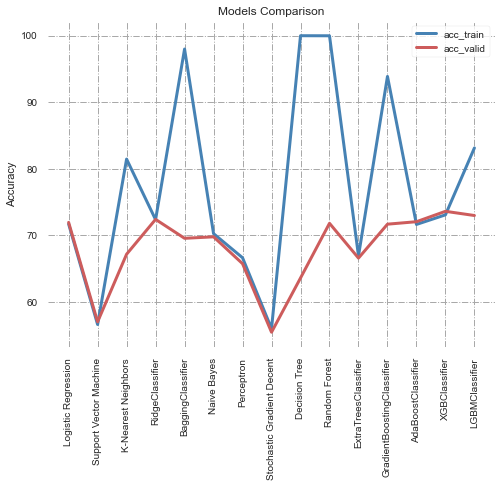

In [45]:
plt.figure(figsize=[8,6])
x = res['model']
plt.plot(x, res['acc_train'], label = 'acc_train', c='steelblue', lw=3)
plt.plot(x, res['acc_valid'], label = 'acc_valid', c='indianred', lw=3)
plt.legend()
plt.grid(ls="-.", lw=1, c='darkgrey')
plt.title('Models Comparison')
plt.ylabel('Accuracy')
plt.xticks(x, rotation='vertical')
plt.savefig('sklearn_compare.png')
plt.show()

## Keras 模型

神经网络是一种比标准机器学习更复杂、更强大的算法，属于深度学习模型。Keras 是一个开源人工神经网络库，可以作为 Tensorflow、Microsoft-CNTK 和 Theano 的高阶应用程序接口，进行深度学习模型的设计、调试、评估、应用和可视化。在这里，我们用 Keras 搭建神经网络，并训练好的网络进行心血管疾病预测。

In [46]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn import metrics

import matplotlib.pyplot as plt

### 神经网络 1

首先，我们先定义一个神经网络，用 Adam 作为优化器。我们这个神经网络包含四个 Dense 层，和两个 Dropout 层。

In [47]:
def build_ann(optimizer='adam'):
    
    # Initializing the ANN
    ann = Sequential()
    
    # Adding the input layer and the first hidden layer of the ANN with dropout
    ann.add(Dense(units=32, kernel_initializer='glorot_uniform', activation='relu', input_shape=(len(train.columns),)))
    
    # Add other layers, it is not necessary to pass the shape because there is a layer before
    ann.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
    ann.add(Dropout(rate=0.5))
    ann.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
    ann.add(Dropout(rate=0.5))
    
    # Adding the output layer
    ann.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
    
    # Compiling the ANN
    ann.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return ann

然后我们就可以调整学习率进行训练（你可以训练更多个 epoch）。

In [48]:
opt = optimizers.Adam(lr=0.001)
ann = build_ann(opt)
# 训练神经网络
history = ann.fit(train, train_labels, batch_size=16, epochs=30, validation_data=(valid, ground_truth))

Epoch 1/30
3880/3880 [==============================] - 4s 1ms/step - loss: 19.7979 - accuracy: 0.5054 - val_loss: 0.6933 - val_accuracy: 0.4964
Epoch 2/30
3880/3880 [==============================] - 3s 895us/step - loss: 0.6931 - accuracy: 0.5050 - val_loss: 0.6933 - val_accuracy: 0.4964
Epoch 3/30
3880/3880 [==============================] - 3s 859us/step - loss: 0.6931 - accuracy: 0.5060 - val_loss: 0.6932 - val_accuracy: 0.4964
Epoch 4/30
3880/3880 [==============================] - 3s 825us/step - loss: 0.6931 - accuracy: 0.5058 - val_loss: 0.6932 - val_accuracy: 0.4964
Epoch 5/30
3880/3880 [==============================] - 3s 836us/step - loss: 0.6931 - accuracy: 0.5053 - val_loss: 0.6934 - val_accuracy: 0.4964
Epoch 6/30
3880/3880 [==============================] - 4s 1ms/step - loss: 0.6931 - accuracy: 0.5060 - val_loss: 0.6934 - val_accuracy: 0.4964
Epoch 7/30
3880/3880 [==============================] - 3s 899us/step - loss: 0.6931 - accuracy: 0.5047 - val_loss: 0.6934 - va

训练之后我们就可以进行结果预测了，但是我们得到的是患病概率，目标输出是患病与否，我们需要将结果转化成二值，在此，为了方便操作，我们直接将概率大于 0.5 的预测定义为患病，然后分别对训练集和验证集的预测结果计算准确率。

In [49]:
# Predicting the Train set results
ann_prediction = ann.predict(train)
ann_prediction = (ann_prediction > 0.5)*1 # convert probabilities to binary output

# Compute error between predicted data and true response and display it in confusion matrix
acc_ann1 = round(metrics.accuracy_score(train_labels, ann_prediction) * 100, 2)
acc_ann1

50.6

In [50]:
# Predicting the Validation set results
ann_prediction_valid = ann.predict(valid)
ann_prediction_valid = (ann_prediction_valid > 0.5)*1 # convert probabilities to binary output

# Compute error between predicted data and true response and display it in confusion matrix
acc_valid_ann1 = round(metrics.accuracy_score(ground_truth, ann_prediction_valid) * 100, 2)
acc_valid_ann1

49.64

### 神经网络 2

我们再构建一个不同的神经网络，使用不同单元个数的 Dense 层和核初始器。

In [51]:
# Model
model = Sequential()
model.add(Dense(16, input_dim = train.shape[1], kernel_initializer='random_uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, kernel_initializer='random_uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, kernel_initializer='random_uniform', activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                208       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                1088      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 3,409
Trainable params: 3,409
Non-trainable params: 0
____________________________________________________

对刚才构建好的神经网络进行训练（你可以训练更多个 epoch）。

In [52]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', patience=20, mode='max')
hist = model.fit(train, train_labels, batch_size=64, validation_data=(valid, ground_truth), 
               epochs=30, verbose=1, callbacks=[es])

Epoch 1/30
970/970 [==============================] - 1s 1ms/step - loss: 0.7078 - accuracy: 0.5061 - val_loss: 0.6935 - val_accuracy: 0.4964
Epoch 2/30
970/970 [==============================] - 1s 1ms/step - loss: 0.6931 - accuracy: 0.5049 - val_loss: 0.6935 - val_accuracy: 0.4964
Epoch 3/30
970/970 [==============================] - 1s 1ms/step - loss: 0.6931 - accuracy: 0.5060 - val_loss: 0.6932 - val_accuracy: 0.4964
Epoch 4/30
970/970 [==============================] - 1s 997us/step - loss: 0.6931 - accuracy: 0.5041 - val_loss: 0.6936 - val_accuracy: 0.4964
Epoch 5/30
970/970 [==============================] - 1s 1ms/step - loss: 0.6931 - accuracy: 0.5060 - val_loss: 0.6932 - val_accuracy: 0.4964
Epoch 6/30
970/970 [==============================] - 1s 1ms/step - loss: 0.6931 - accuracy: 0.5060 - val_loss: 0.6933 - val_accuracy: 0.4964
Epoch 7/30
970/970 [==============================] - 1s 1ms/step - loss: 0.6931 - accuracy: 0.5060 - val_loss: 0.6932 - val_accuracy: 0.4964
Epoc

同理，我们需要对两个数据集的预测结果进行二值化处理，然后计算预测准确率。

In [56]:
# Predicting the Train set results
nn_prediction = model.predict(train)
nn_prediction = (nn_prediction > 0.5)*1 # convert probabilities to binary output

# Compute error between predicted data and true response
acc_ann2 = round(metrics.accuracy_score(train_labels, nn_prediction) * 100, 2)
acc_ann2

50.6

In [57]:
# Predicting the Validation set results
nn_prediction_valid = model.predict(valid)
nn_prediction_valid = (nn_prediction_valid > 0.5)*1 # convert probabilities to binary output

# Compute error between predicted data and true response
acc_test_ann2 = round(metrics.accuracy_score(ground_truth, nn_prediction_valid) * 100, 2)
acc_test_ann2

49.64

通过比较神经网络和其他机器学习方法得到的预测准确率，我们发现，XGB 和 LGBM 依然是预测准确率最高的两个模型。

## 结语

本实训用 Sklearn 和 Keras 工具构建了数个心血管疾病预测模型，用预处理好的数据给不同模型训练，我们得到了不同模型的预测结果。我们发现，XGB 和 LGBM 是预测准确率最高的两个模型，最高准确率在验证集可达 70% 左右。